In [175]:

import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage as ndi
from scipy import fft, ifft

from skimage import data
from skimage import io, transform
from skimage.util import img_as_float, pad
from skimage.filters import gabor_kernel

import pickle 
import os
import sys
import h5py

import llorg_utils as l

# importing some helper packages for coco and for image processing.
sys.path.append('/user_data/mmhender/coco_annot/cocoapi/PythonAPI/')
from pycocotools.coco import COCO
sys.path.append('/user_data/mmhender/fwrf/gaborizer/src/')
# import src.fwrf as fwrf
import features
import gabor_feature_dictionaries

In [183]:
orientations = 4
deg_per_stimulus = 18
cycles_per_deg = (0.5, 2, 5)

feats = gabor_feature_dictionaries.gabor_feature_maps(orientations,deg_per_stimulus,cycles_per_deg,
                     freq_spacing='log',
                     pix_per_cycle=2,cycles_per_radius=1,diams_per_filter=2,complex_cell=True,color_channels=1)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [155]:
# load a test COCO image to start with
annot_file = '/user_data/mmhender/coco_annot/annotations/instances_val2017.json'
coco_val = COCO(annot_file)
coco=coco_val
coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/val2017'
nsd_ind = 5 # index into the 73000 NSD images
# gather metadata for these images and load the one of interest
nsd_brick_file = '/lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5'
nsd_meta_file = '/lab_data/tarrlab/common/datasets/NSD/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'
with h5py.File(nsd_brick_file, "r") as f:
    nsd_im = f['imgBrick'][nsd_ind,:,:,:]   
with open(nsd_meta_file,'rb') as f:
    stim_info = pickle.load(f,encoding="latin1")
    
# from metadata, get the COCO Id number of the image
coco_id_code = stim_info['cocoId'][nsd_ind]
coco_im_info = coco.loadImgs(ids=[coco_id_code])
imfn = os.path.join(coco_image_dir, coco_im_info[0]['file_name'])
coco_im = io.imread(imfn)

np.shape(nsd_im)


loading annotations into memory...
Done (t=0.85s)
creating index...
index created!


(425, 425, 3)

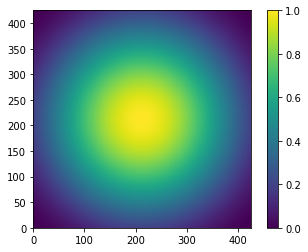

In [81]:
x,y = np.meshgrid(np.arange(0,np.shape(nsd_im)[0]), (np.arange(0,np.shape(nsd_im)[0])))
center = np.median(x)
dist_from_center = np.sqrt((x-center)**2+(y-center)**2)
dist_from_center = dist_from_center/np.max(dist_from_center)*(np.pi)
cos_mask = (np.cos(dist_from_center)+1)/2
plt.figure();
plt.pcolormesh(cos_mask)
plt.axis('square')
plt.colorbar()


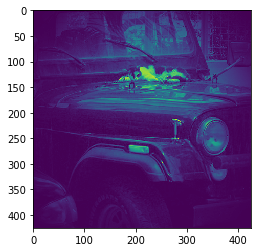

In [89]:
image_masked = nsd_im*np.tile(np.expand_dims(cos_mask,2),[1,1,3])
plt.figure();
plt.pcolormesh(image_masked[:,:,0])
plt.axis('square')
plt.gca().invert_yaxis()

(69, 69)
(49, 49)
(69, 69)
(49, 49)


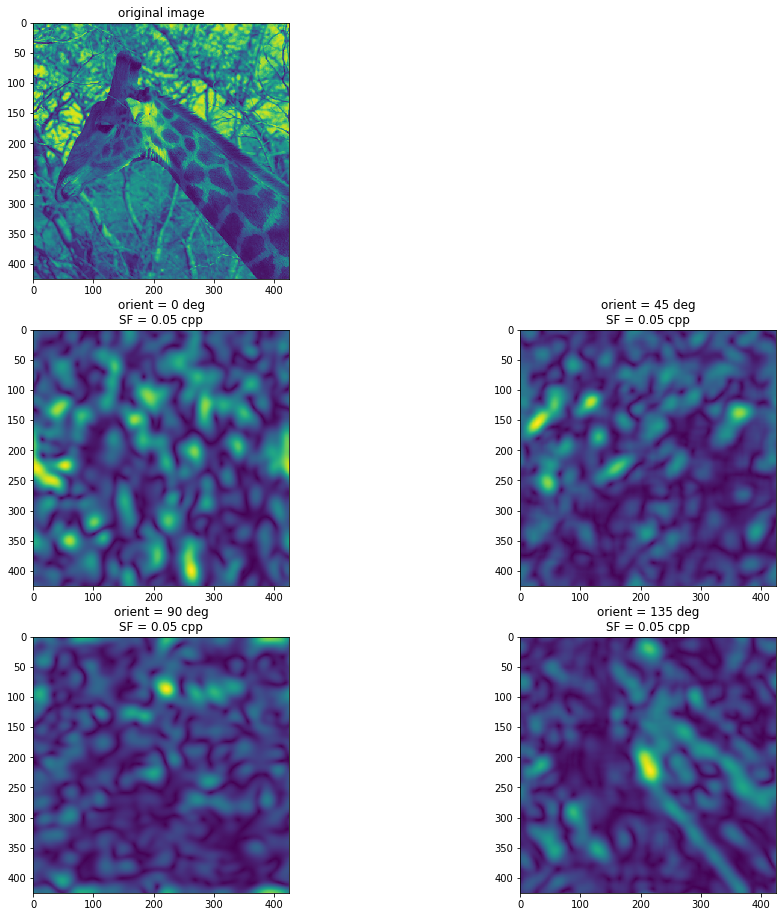

In [144]:
# test filtering in spatial domain
freq_cpp = 0.05;
orients_deg = [0,45,90,135]
plt.figure(figsize=(16,16));

plt.subplot(3,2,1)
plt.pcolormesh(np.mean(nsd_im,axis=2))
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('original image')

for ii in range(len(orients_deg)):
    
    orient_rad = orients_deg[ii]/180*np.pi
#     kernel = gabor_kernel(frequency=freq_cpp, theta=orient_rad, bandwidth=0.5)
    kernel = l.makeSpatGabor(orients_deg[ii], freq_cpp, spat_freq_bw=1, spat_aspect_ratio=1)
    print(np.shape(kernel))
    filtered = ndi.convolve(nsd_im[:,:,0], kernel, mode='wrap')
#     filtered = ndi.convolve(np.mean(nsd_im,axis=2), kernel, mode='constant', cval=0)
    
    plt.subplot(3,2,3+ii)
#     plt.pcolormesh(np.real(kernel))
#     plt.pcolormesh(fft.fftshift(np.abs(fft.fft2(kernel))))
    plt.pcolormesh(np.abs(filtered))
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('orient = %d deg\nSF = %.2f cpp'%(orients_deg[ii],freq_cpp))
    

In [153]:
def makeSpatGabor(orient_deg, freq_cpp, image_size=None, spat_freq_bw=None, spat_aspect_ratio=None):
        
    """
    Construct a spatial kernel for Gabor filter.
    """ 

    # First set some parameters
    orient_rad = orient_deg/180*np.pi
    wavelength_pix = 1/freq_cpp

    # bandwidth sets the number of cycles that fall within the Gaussian envelope surrounding the Gabor.
    # smaller bandwidth == larger radius of the envelope.
    # small bandwidth value also makes the final size of the kernel larger.
    if spat_freq_bw==None:
        spat_freq_bw = 1
    if spat_aspect_ratio==None:
        spat_aspect_ratio = 0.5
    if image_size==None:
        image_size = [400,400]
    M = image_size[0]
    N = image_size[1]
    # start to create a grid in frequency domain
    u = np.linspace(0,1,N) 
    v = np.linspace(0,1,M)
    [U,V] = np.meshgrid(u,v)
    
    # going to solve for the x and y standard deviations needed 
    # (based on wavelength and spatial frequency bandwidth already defined)
    # From relationship in "Nonlinear Operator in Oriented Texture", Kruizinga,
    # Petkov, 1999.
    # Larger sigma_x, sigma_y == larger radius (in pixels) in those specified directions.
    SigmaX = wavelength_pix/np.pi*np.sqrt(np.log(2)/2)*(2**spat_freq_bw+1)/(2**spat_freq_bw-1);
    SigmaY = SigmaX / spat_aspect_ratio;
    
    gabor_spat = gabor_kernel(frequency=freq_cpp, theta=orient_rad,sigma_x=SigmaX,sigma_y=SigmaY)

    return gabor_spat

0j

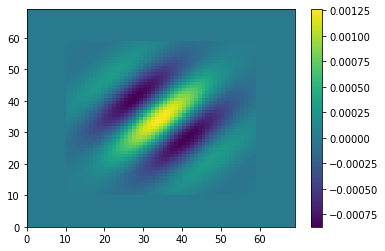

In [152]:
kernel = l.makeSpatGabor(orients_deg[ii], freq_cpp, spat_freq_bw=1, spat_aspect_ratio=1)
kernel_padded = np.pad(kernel, [[10,10],[10,10]])
plt.figure();
plt.pcolormesh(np.real(kernel_padded));plt.colorbar()


dict_keys(['phase', 'mag', 'mean_phase', 'mean_mag', 'orient_labs', 'freq_labs', 'orig_size', 'padded_size'])


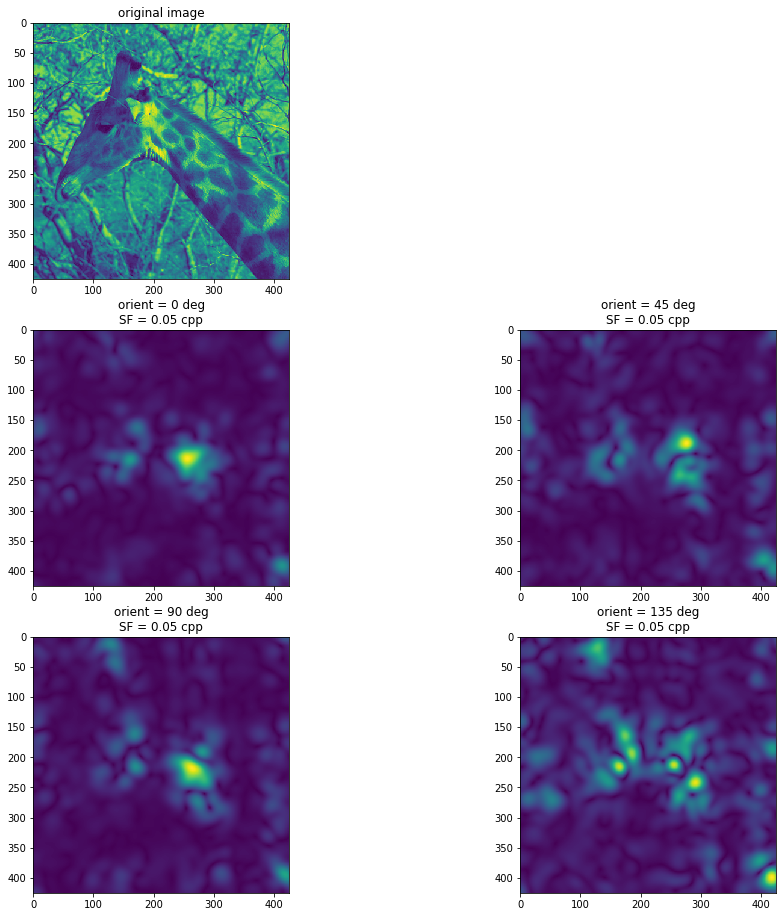

In [139]:
orients_deg = [0,45,90,135]
freqs_cpp = [0.05]
grid_positions_pix = [1,2]
padded_size = (1012,1012)
# params = {'R_MEAN':124, 'G_MEAN': 117, 'B_MEAN': 104,
#                  'process_at_size': 425, 'size_after_pad': padded_size}
params = {'R_MEAN':0, 'G_MEAN': 0, 'B_MEAN': 0,
                 'process_at_size': 425, 'size_after_pad': padded_size}
bank = filter_bank(orients_deg, freqs_cpp, grid_positions_pix, padded_size)
# filter_stack_freq, orient_labs, freq_labs = bank.get_filters_freq()

# filter_whole_image(image_masked, bank, params=params)
image_stats, filters = filter_whole_image(nsd_im, bank, params = params)
orient_labs = image_stats['orient_labs']
freq_labs = image_stats['freq_labs']
print(image_stats.keys())

plt.figure(figsize=(16,16));

plt.subplot(3,2,1)
plt.pcolormesh(nsd_im[:,:,0])
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('original image')

for ii in range(len(orient_labs)):
    
    plt.subplot(3,2,3+ii)
#     plt.pcolormesh(np.real(filter_stack_freq[:,:,ii]))
    plt.pcolormesh(image_stats['mag'][:,:,ii])
#     plt.pcolormesh(np.abs(filters[:,:,ii]))
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))

In [118]:
class filter_bank:
    
     def __init__(self, orients_deg, freqs_cpp, grid_positions_pix, padded_image_size):
        
        self.orients_deg = orients_deg;
        self.freqs_cpp = freqs_cpp;
        self.grid_positions_pix = grid_positions_pix
        self.padded_image_size = padded_image_size
        self.n_filt_total = len(orients_deg)*len(freqs_cpp)
        
     def get_filters_freq(self):
    
        filter_stack_freq_realpart = np.zeros((self.padded_image_size[0],self.padded_image_size[1],self.n_filt_total))
        filter_stack_freq_imagpart = np.zeros((self.padded_image_size[0],self.padded_image_size[1],self.n_filt_total))
        
        ii=-1
        orient_labs = np.zeros((self.n_filt_total,1))
        freq_labs = np.zeros((self.n_filt_total,1))
        
        for [oi, orient_deg] in enumerate(self.orients_deg):
            for [fi, freq_cpp] in enumerate(self.freqs_cpp):
                ii=ii+1;
                this_freq_filter = l.makeFreqGabor(orient_deg, freq_cpp, image_size=self.padded_image_size, 
                                                  spat_freq_bw=1, spat_aspect_ratio=1)
                filter_stack_freq_realpart[:,:,ii] = np.real(this_freq_filter)
                filter_stack_freq_imagpart[:,:,ii] = np.imag(this_freq_filter)
                orient_labs[ii] = orient_deg
                freq_labs[ii] = freq_cpp
                
        return filter_stack_freq_realpart + 1j* filter_stack_freq_imagpart, orient_labs, freq_labs

In [126]:
def filter_whole_image(image, bank, params=None):
    """
    Apply filter bank to entire image.
    """
    if params==None:
      params = default_params
                                      
    R_MEAN = params['R_MEAN'];
    G_MEAN = params['G_MEAN'];
    B_MEAN = params['B_MEAN'];
    process_at_size = params['process_at_size'];
    size_after_pad = params['size_after_pad'];
    filters_freq, orient_labs, freq_labs = bank.get_filters_freq()

    # Preprocessing: 
    # subtract the background color (if images are circularly windowed, this is the mid-gray color of background)
    # up to this point - all image values are in the range 0-255. When we
    # subtract the mean, some values will go negative. 
    image = image.astype('float64')
    image = image - np.moveaxis( np.tile(np.expand_dims(np.expand_dims([R_MEAN,G_MEAN,B_MEAN],1),2),
                                    [np.shape(image)[0],np.shape(image)[1]]),0,-1)
    # make it grayscale
    if np.shape(image)[2]==3:
        grey_image = np.round(np.mean(image,axis=2),0);
    image = grey_image;
    
    orig_size = np.shape(grey_image);

    # make sure it's the size we expect
    assert(orig_size[0]==process_at_size & orig_size[1]==process_at_size)
                                      
    # Zero-pad the image for filtering
    pad_by = (np.array(size_after_pad) - np.array(orig_size))/2   
    n2pad = np.transpose(np.array([np.floor(pad_by),np.ceil(pad_by)]).astype('int'));   
    # n2pad goes [[x1, x2],[y1, y2]]
    image_padded = np.pad(grey_image,n2pad)

    padded_size = np.shape(image_padded);
    assert(padded_size[0]==size_after_pad[0] and padded_size[1]==size_after_pad[1])

    # Filtering:
    # fft into frequency domain
    image_fft = fft.fft2(image_padded,axes=[0,1]);

    # Apply all my filters all at once
    filtered_freq_domain = np.tile(np.expand_dims(image_fft,2),[1,1,np.shape(filters_freq)[2]])*filters_freq;

    # get back to the spatial domain
    out_full = fft.ifft2(filtered_freq_domain,axes=[0,1]);

    # un-pad the image (back to its down-sampled size)
    out = out_full[n2pad[0,0] : n2pad[0,0]+process_at_size, n2pad[1,0]:n2pad[1,0]+process_at_size,:];
    assert(np.shape(out)[0]==process_at_size and np.shape(out)[1]==process_at_size)

    mag = np.abs(out);
    phase = np.angle(out);

    #  add all this info to my structure
    image_stats={}
                                      
    image_stats['phase'] = phase;
    image_stats['mag'] = mag;
    image_stats['mean_phase'] = np.squeeze(np.mean(np.mean(phase,1),0));
    image_stats['mean_mag'] = np.squeeze(np.mean(np.mean(mag,1),0));
    image_stats['orient_labs'] = orient_labs;
    image_stats['freq_labs'] = freq_labs;
    image_stats['orig_size'] = orig_size;
    image_stats['padded_size'] = padded_size;
                                      
    return image_stats, filters_freq

(35, 35)


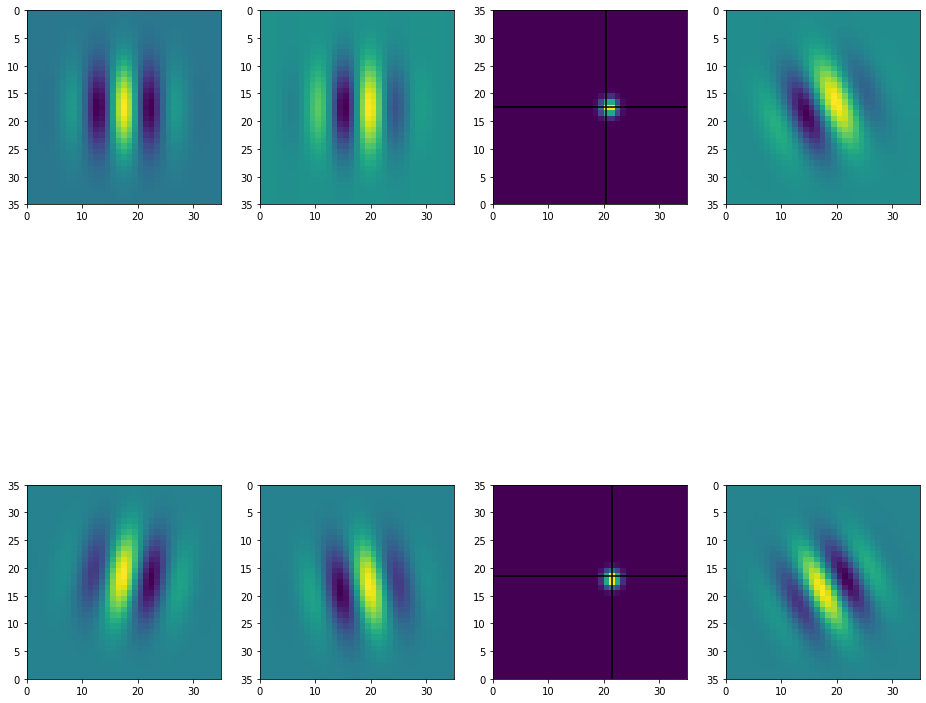

In [141]:
# Comparing frequency domain and spatial domain rep of gabor filters
# Check to make sure we get the same thing a few different ways...
# First set some parameters
orient_deg=0
freq_cpp = 0.1;
# bandwidth sets the number of cycles that fall within the Gaussian envelope surrounding the Gabor.
# smaller bandwidth == larger radius of the envelope.
# small bandwidth value also makes the final size of the kernel larger.
spat_freq_bw = 1;
spat_aspect_ratio = 1


plt.figure(figsize=(16,16));

# Method 1: make a gabor in spatial domain, fft to frequency domain

gabor_spat1 = l.makeSpatGabor(orient_deg, freq_cpp, 
                                       spat_freq_bw=spat_freq_bw,spat_aspect_ratio = spat_aspect_ratio)
# gabor_spat1 = gabor_kernel(frequency=freq_cpp, theta=orient_rad,sigma_x=SigmaX,sigma_y=SigmaY,n_stds=n_stds)
print(np.shape(np.real(gabor_spat1)))
plt.subplot(2,4,1)
plt.pcolormesh(np.real(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()

# flipping the y axis here - so positive orientation is rotating clockwise from vertical.
plt.subplot(2,4,2)
plt.pcolormesh(np.imag(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,3)
gabor_freq1 = fft.fftshift(fft.fft2(gabor_spat1))
plt.pcolormesh(np.abs(gabor_freq1))
# plt.pcolormesh(np.abs(fft.fftshift(gabor_freq1)))
plt.axis('square')
m = np.argmax(np.max(np.abs(gabor_freq1),axis=1),axis=0)
n = np.argmax(np.max(np.abs(gabor_freq1),axis=0),axis=0)
plt.axhline(m+0.5,color='k')
plt.axvline(n+0.5,color='k')
# positive orientation in SF domain is counter-clockwise from rightmost pt.

gabor_spat1_new = fft.ifft2(fft.fftshift(gabor_freq1))
plt.subplot(2,4,4)
plt.pcolormesh(np.imag(gabor_spat1_new))
plt.axis('square')
plt.gca().invert_yaxis()


# Method 2: make a gabor in frequency domain, then convert back to spatial
# specify the size, based on size from other method
M = np.shape(gabor_spat1)[0] # works better when even num pixels
N = np.shape(gabor_spat1)[1]
gabor_freq2 = l.makeFreqGabor(orient_deg, freq_cpp, image_size=[M,N], 
                                       spat_freq_bw=spat_freq_bw,spat_aspect_ratio = spat_aspect_ratio)

plt.subplot(2,4,7);
plt.pcolormesh(np.abs(gabor_freq2))
# plt.pcolormesh(np.abs(fft.fftshift(gabor_freq2)))
plt.axis('square')
# plt.gca().invert_yaxis()
# positive orientation in SF domain is counter-clockwise from rightmost pt.
m = np.argmax(np.max(np.abs(gabor_freq2),axis=1),axis=0)
n = np.argmax(np.max(np.abs(gabor_freq2),axis=0),axis=0)
plt.axhline(m+0.5,color='k')
plt.axvline(n+0.5,color='k')

gabor_spat2 = fft.ifftshift(fft.ifft2(fft.fftshift(gabor_freq2)))
# gabor_spat2 = fft.fftshift(gabor_freq2))
plt.subplot(2,4,5);
plt.pcolormesh(np.real(gabor_spat2))
plt.axis('square')

# positive orientation is rotating clockwise from vertical.
plt.subplot(2,4,6)
plt.pcolormesh(np.imag(gabor_spat2))
plt.axis('square')
plt.gca().invert_yaxis()

# positive orientation is rotating clockwise from vertical.
plt.subplot(2,4,8)
gabor_spat2_new = fft.ifftshift(fft.ifft2(fft.fftshift(np.flipud(gabor_freq2))))
plt.pcolormesh(np.real(gabor_spat2_new))
plt.axis('square')
plt.gca().invert_yaxis()


In [6]:
float64(M)

NameError: name 'float64' is not defined

In [4]:
print([M/2,N/2])
print([m,n])
np.abs(gabor_freq2[28:31,n])

[15.0, 29.0]
[21, 29]


array([9.53775124e-26, 1.10765250e-28])

(23, 23)
(23, 23)
[3.6406420080887547, 3.6406420080887547]
[23.0]
1.2515822356100586e-16


Text(0.5, 1.0, 'freq = 0.25 cycles/pixel')

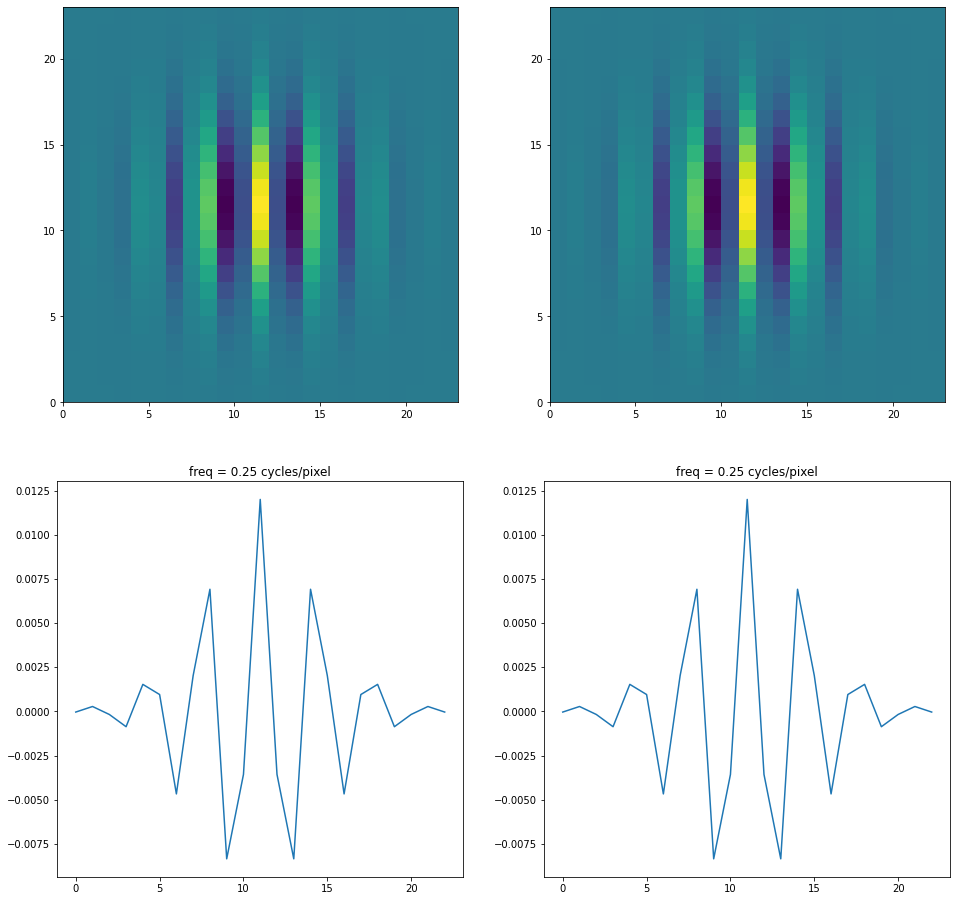

In [163]:
# trying to check what the parameters are for Gabor kernel function in sklearn
orient_deg=0
orient_rad = orient_deg/180*np.pi
freq_cpp = 0.3;
image_size = [800,800]

wavelength_pix = 1/freq_cpp
spat_freq_bw = 0.5
spat_aspect_ratio = 1
# for a given "spatial frequency bandwidth"
# can convert to the SD of the kernel in pixels 
SigmaX = wavelength_pix/np.pi*np.sqrt(np.log(2)/2)*(2**spat_freq_bw+1)/(2**spat_freq_bw-1);
SigmaY = SigmaX / spat_aspect_ratio;
# smaller bandwidth == larger radius (in pixels) of the Gaussian envelope surrounding the Gabor. 
# Makes the final size of the kernel larger.
# Larger sigma_x, sigma_y == larger radius (in pixels) in those specified directions (relative to orient=0)

plt.figure(figsize=(16,16));
plt.subplot(2,2,1)
gabor_spat1 = np.real(gabor_kernel(frequency=freq_cpp, theta=orient_rad,bandwidth=spat_freq_bw))
print(np.shape(gabor_spat1))
plt.pcolormesh(gabor_spat1)
plt.axis('square')

plt.subplot(2,2,2)
gabor_spat2 = np.real(gabor_kernel(frequency=freq_cpp, theta=orient_rad, sigma_x=SigmaX, sigma_y=SigmaY))
print(np.shape(gabor_spat2))
plt.pcolormesh(gabor_spat2)
plt.axis('square')

print([SigmaX,SigmaY])
print([np.ceil(3*SigmaX+3*SigmaY+1)])
print(np.sum(np.abs(gabor_spat1-gabor_spat2)))

plt.subplot(2,2,3)
center_ind = int(np.shape(gabor_spat1)[0]/2)
plt.plot(gabor_spat1[center_ind,:])
wavelength = 2*(np.argmax(gabor_spat1[center_ind,:]) - np.argmin(gabor_spat1[center_ind,:]))
plt.title('freq = %.2f cycles/pixel'%(1/wavelength))

plt.subplot(2,2,4)
center_ind = int(np.shape(gabor_spat2)[0]/2)
plt.plot(gabor_spat2[center_ind,:])
wavelength = 2*(np.argmax(gabor_spat2[center_ind,:]) - np.argmin(gabor_spat2[center_ind,:]))
plt.title('freq = %.2f cycles/pixel'%(1/wavelength))